In [4]:
# ~\anaconda3\envs\myenv2\python.exe
# -*- coding: utf-8 -*-
"""
Created on Mon Nov  9 11:51:34 2020

@author: ChingTseTing
"""

import os
import sys
import random
import numpy as np
from numpy.random import seed
import pandas as pd
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA

from matplotlib import pyplot
import matplotlib.pyplot as plt

import tensorflow as tf

from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model

from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from keras import optimizers
from keras.layers import LeakyReLU
from keras.regularizers import l2

# fix random seed for reproducibility
seed(7)

Data Processing for training data

In [5]:
# Read Training data
with open('C:\\Users\\lab619\\Music\\DeepDTI\\data\\drug_target_1.pickle', 'rb') as f:
    data_1 = pickle.load(f)
with open('C:\\Users\\lab619\\Music\\DeepDTI\\data\\drug_target0.pickle', 'rb') as f:
    data_0 = pickle.load(f)

data_0 = data_0.sample(n=80291, random_state=1)
data_0 = data_0.reset_index(drop=True)
data_1 = np.concatenate([data_1.iloc[i,0].tolist() for i in range(len(data_1))])
data_0 = np.concatenate([data_0.iloc[i,0].tolist() for i in range(len(data_0))])
drug_target = np.concatenate((data_1, data_0), axis=0)
label = np.concatenate((np.ones(data_1.shape[0]),np.zeros(data_0.shape[0])))
del data_1
del data_0

# train data preprocess: train test split
X_train, X_test, Y_train, Y_test = train_test_split(drug_target, label, test_size=0.3, random_state=0)

# train data preprocess: feature scaling (standarization)
scaler = StandardScaler()
scaler.fit(X_train)
XX_train = scaler.transform(X_train)
XX_test = scaler.transform(X_test)

# train data preprocess: PCA transform
pca_x  = PCA(n_components=1000)
pca_x.fit(XX_train)
x_train = pca_x.transform(XX_train)
x_test = pca_x.transform(XX_test)


Data proprocessing for new data (your biomarker-drug pairs)

In [6]:
with open("C:\\Users\\lab619\\Music\\DeepDTI\\code\\drug_target_descriptor\\target_gene_CT.pickle", 'rb') as file:
    target_database = pickle.load(file, encoding='iso-8859-1')
Target_list = target_database['gene_name'].tolist()

for name in Target_list:
    with open('C:\\Users\\lab619\\Music\\DeepDTI\\data\\biomarkers_descriptor\\' + 'drug_%s_descriptor.pickle'%name, 'rb') as f:
        tmp = pickle.load(f)
        trans = scaler.transform(tmp)         # train data preprocess: train test split
        trans1 = pca_x.transform(trans)       # train data preprocess: feature scaling (standarization)
        trans_save = pd.DataFrame(trans1)     # train data preprocess: PCA transform
        with open('C:\\Users\\lab619\\Music\\DeepDTI\\data\\biomarkers_descriptor\\' + 'drug_%s_descriptor_transform.pickle'%name, 'wb') as f:
            pickle.dump(trans_save, f)

Define Deep-Neuron-Network drug-target interaction model architecture


In [7]:
def DNN(x_train, Y_train, x_test, Y_test, VALIDATION_SPLIT ,LEARNING_RATE, EPOCHS, BATCH_SIZE ):
    model=Sequential()
    model.add(Dense(units=512, input_dim=1000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units=1, activation='sigmoid'))

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)

    opt = optimizers.Adam(learning_rate= LEARNING_RATE)
    model.compile(loss='binary_crossentropy', optimizer= opt, metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    model.summary()

    train_history = model.fit(x=x_train, y=Y_train, validation_split=VALIDATION_SPLIT,epochs=EPOCHS , batch_size=BATCH_SIZE, verbose=1, callbacks=[es])
    #train_history = model.fit(x=X_train, y=y_train, validation_split=0.1,epochs=100, batch_size=100, verbose=1)

    model.save('C:\\Users\\lab619\\Music\\DeepDTI\\model\\DeepDTI_GC_new.h5')
    scores= model.evaluate(x_test, Y_test, verbose = 0)

    train_acc = train_history.history['accuracy']
    val_acc = train_history.history['val_accuracy']
    train_AUC = train_history.history['auc']
    val_AUC = train_history.history['val_auc']

    test_acc = scores[1]

    pre = model.predict(x_test)
    fpr,tpr,threshold = roc_curve(Y_test, pre)
    test_AUC = auc(fpr, tpr)

    total = [train_acc[-1], val_acc[-1], test_acc, train_AUC[-1], val_AUC[-1], test_AUC]
    result = pd.DataFrame([total], columns=['train_acc', 'val_acc', 'test_acc', 'train_AUC', 'val_AUC', 'test_AUC'])

    return train_history, result

Traing Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

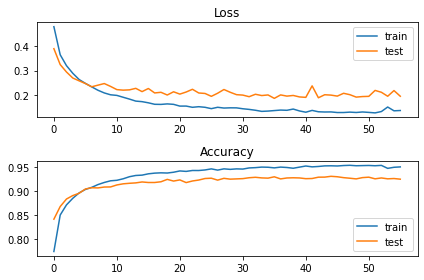

In [8]:
# train DNN model  5-fold cross validation : VALIDATION_SPLIT = 1/5
train_history, result = DNN(x_train, Y_train, x_test, Y_test,0.2 ,0.003 , 100 , 100 )  

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(train_history.history['loss'], label='train')
pyplot.plot(train_history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(train_history.history['accuracy'], label='train')
pyplot.plot(train_history.history['val_accuracy'], label='test')
pyplot.legend()
plt.tight_layout()
pyplot.show()